In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import miniscope_utils_tf as tf_utils
from miniscope_model import Model as msu_model
import scipy as sc
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
import scipy.io
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import cv2 as cv2

import os
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation

/home/nick/Miniscope3D/miniscope_model.py:224: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(Nz_in == self.Nz,'Measured PSF has different number of zplanes than model')


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
zernikes_index =[3,4,5,6,7,8,9,10,11,12,13,14]
model_opt = sc.io.loadmat('../designs/1kiter_l2_z3-14_atten_nanoscribe_v1_20190820_112303.mat')
xopt = model_opt['xpos'][0]
yopt = model_opt['ypos'][0]
ropt = model_opt['rlist'][0]
zern_list = zernikes_index
zern_coeffs = model_opt['zern_coeffs']
defocus_list_opt = model_opt['defocus_list'][0]
defocus_err_opt = model_opt['defocus_correction'][0]
atten_opt = model_opt['atten'][0][0]
defocus_list = 1./(1./defocus_list_opt + defocus_err_opt)

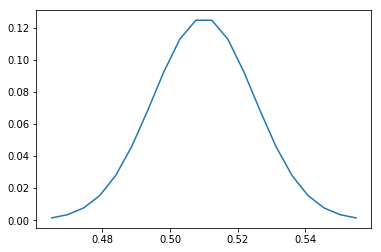

In [5]:
fl_center = 510e-3 #Microns
fl_sig = 15e-3
lam = np.linspace(fl_center-3*fl_sig,fl_center+3*fl_sig,20)
S = np.exp(-(lam - fl_center)**2/(2*fl_sig**2))
S = S/np.sum(S)
plt.figure()
plt.plot(lam,S)

In [6]:
model = msu_model(Nlenslets = 37, aberrations = True, zernikes = zernikes_index,loss_type='none',psf_scale=1e2,
                  lenslet_CA=0.2e3,lenslet_spacing = 'uniform',psf_file='../psf_meas/psf_crop_nanoscribe_v1_re-registered_2xds.mat',incoherent_source = False)

In [7]:

for m in range(len(lam)):
    model = msu_model(Nlenslets = 37, aberrations = True, zernikes = zernikes_index,loss_type='none',psf_scale=1e2,
                      lenslet_CA=0.2e3,lenslet_spacing = 'uniform',psf_file='../psf_meas/psf_crop_nanoscribe_v1_re-registered_2xds.mat',
                      incoherent_source = False, lam = lam[m])
    model.zern_coefficients.assign(zern_coeffs)
    model.xpos.assign(xopt)
    model.ypos.assign(yopt)
    model.rlist.assign(ropt)
    model.atten.assign(atten_opt)
    Trot,aper= tf_utils.make_lenslet_tf_zern(model)
    coh_zstack = model.gen_psf_stack(Trot,aper,0,1./(1./defocus_list+model.defocus_offset))
    if m is 0:
        incoh_zstack = [coh_zstack[n].numpy()*S[m] for n in range(model.Nz)]
    else:
        incoh_zstack = [incoh_zstack[n] + coh_zstack[n].numpy()*S[m] for n in range(model.Nz)]
    print(m)
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [8]:
def downsample_2x(im):
     return(0.25*(im[::2,::2] + im[1::2,::2] + im[::2,1::2] + im[1::2,1::2]))

In [ ]:
# Trot,aper= tf_utils.make_lenslet_tf_zern(model)
# psf_init_zstack = model.gen_psf_stack(Trot,aper,0,1./(1./defocus_list+model.defocus_offset))


In [9]:
def drawnow():
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [28]:
psf_out = np.array([downsample_2x(incoh_zstack[n]) for n in range(model.Nz)])
psf_out = np.moveaxis(psf_out,0,-1)
print(np.shape(psf_out))
#sc.io.savemat('../designs/1kiter_l2_z3-14_atten_nanoscribe_v1_20190820_112303_zstack.mat',{'zstack':psf_out})

(1944, 2592, 10)


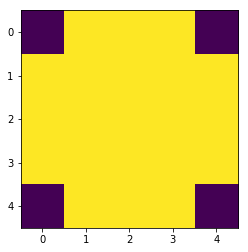

In [41]:
mag = 6.1   #System magnification
bead_size = .8
bead_size_sensor = np.ceil(bead_size*mag/model.px)

# Construct the circular convolution kernel of size bead_size_sensor (in diameter)
xkern = np.r_[-np.floor(bead_size_sensor/2):np.ceil(bead_size_sensor/2)]
Xkern, Ykern = np.meshgrid(xkern,xkern)
Rkern = np.sqrt(Xkern**2 + Ykern**2)
kern_numpy = (Rkern<=(bead_size_sensor/2)) /np.sum(Rkern)
# Rkern = np.atleast_3d(np.sqrt(Xkern**2 + Ykern**2))
# Rkern = np.moveaxis(Rkern,2,0)

kern = tf.constant(kern_numpy,tf.float32)
plt.figure()
plt.imshow(kern)

In [37]:
zstack_tf = tf.constant(incoh_zstack)


InvalidArgumentError: Value for attr 'padding' of "same" is not in the list of allowed values: "SAME", "VALID"
	; NodeDef: {{node Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="same", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dummy_input, dummy_input); Op<name=Conv2D; signature=input:T, filter:T -> output:T; attr=T:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]; attr=strides:list(int); attr=use_cudnn_on_gpu:bool,default=true; attr=padding:string,allowed=["SAME", "VALID"]; attr=data_format:string,default="NHWC",allowed=["NHWC", "NCHW"]; attr=dilations:list(int),default=[1, 1, 1, 1]> [Op:Conv2D] name: convolution/

<tf.Tensor: id=219175, shape=(3888, 5184), dtype=float32, numpy=
array([[5.8333383e-10, 6.1989341e-10, 6.5897232e-10, ..., 5.0583154e-10,
        5.2571963e-10, 5.5160065e-10],
       [5.2134064e-10, 5.1326304e-10, 5.1422322e-10, ..., 5.5792054e-10,
        5.4889665e-10, 5.3493016e-10],
       [4.5564594e-10, 4.0415729e-10, 3.6076411e-10, ..., 5.7571975e-10,
        5.5007454e-10, 5.0730981e-10],
       ...,
       [4.5059412e-10, 3.9886092e-10, 3.5263653e-10, ..., 6.0401661e-10,
        5.5425275e-10, 5.0313048e-10],
       [3.5994782e-10, 3.6457271e-10, 3.6236597e-10, ..., 3.2538078e-10,
        3.3630335e-10, 3.4943518e-10],
       [4.2899873e-10, 4.7888471e-10, 5.2148880e-10, ..., 2.8482822e-10,
        3.2673461e-10, 3.7652037e-10]], dtype=float32)>

In [42]:
zstack_blur = [tf_utils.tf_2d_conv(downsample_2x(zstack_tf[n]),kern,'SAME') for n in range(model.Nz)]


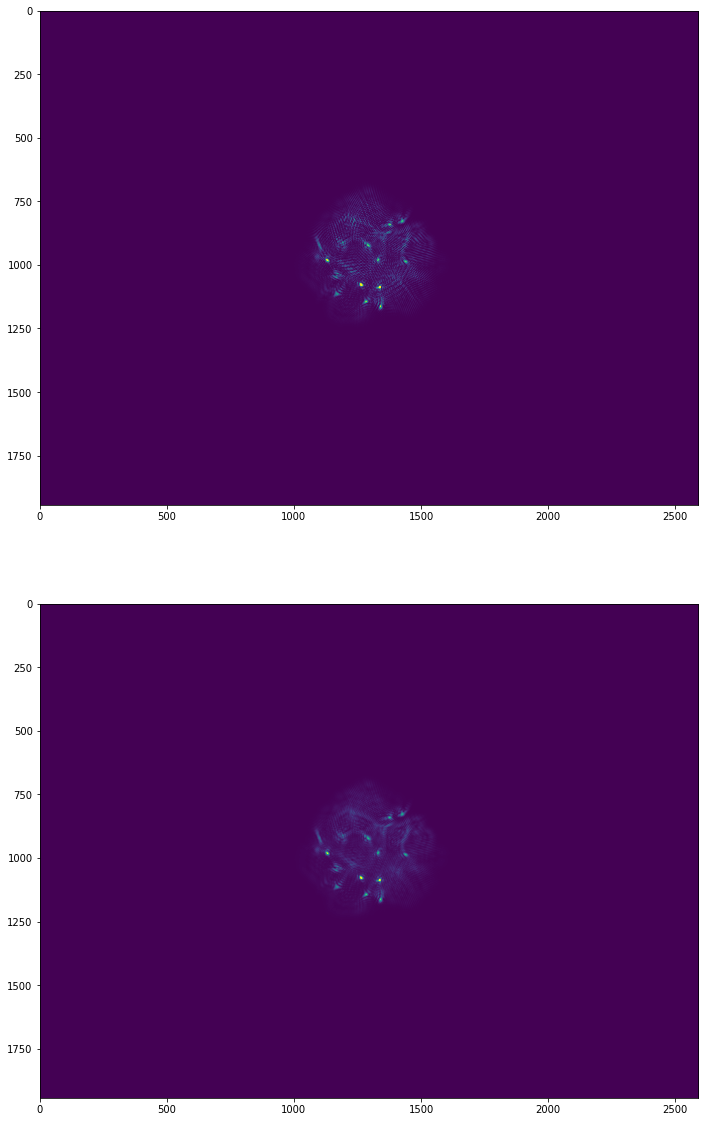

In [47]:

fig,ax = plt.subplots(2,1,figsize=(20,20))
for n in [7]:
    ax[0].imshow(downsample_2x(incoh_zstack[n]),vmax=.002)
    #ax[1].imshow(downsample_2x(coh_zstack[n]),vmax=.002)
    ax[1].imshow(zstack_blur[n].numpy(), vmax=.001)
    drawnow()

In [48]:
psf_out = np.array([zstack_blur[n].numpy() for n in range(model.Nz)])
psf_out = np.moveaxis(psf_out,0,-1)
sc.io.savemat('../designs/1kiter_l2_z3-14_atten_nanoscribe_v1_20190820_112303_zstack_blur.mat',{'zstack':psf_out})